In [ ]:
# (C) Copyright IBM Corp. 2019, 2020, 2021, 2022.

#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at

#           http://www.apache.org/licenses/LICENSE-2.0

#     Unless required by applicable law or agreed to in writing, software
#     distributed under the License is distributed on an "AS IS" BASIS,
#     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#     See the License for the specific language governing permissions and
#     limitations under the License.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from simulai.utilities.lorenz_solver import lorenz_solver
from simulai.regression import OpInf
from simulai.math.integration import LSODA, ClassWrapper
from simulai.metrics import L2Norm
from simulai.templates import HyperTrainTemplate
from simulai.workflows import ParamHyperOpt

Class for Defining Lorenz 63 Jacobian. It can be useful for time-integration purposes.

In [2]:
class LorenzJacobian:

    def __init__(self, sigma=None, rho=None, beta=None):
        self.sigma = sigma
        self.rho = rho
        self.beta = beta

    def __call__(self, data):

            x = data[0]
            y = data[1]
            z = data[2]

            return np.array([
                            [ self.sigma, self.sigma,    0],
                            [-z + self.rho, -1,         -x],
                            [     y,         x, -self.beta]
                           ])

This class constructs a hyper-problem template for Lorenz 63. 

In [3]:
class HyperOpInfTwoParameters(HyperTrainTemplate):

    def __init__(self, trial_config: dict = None, set_type='hard', path_to_model: str = None,
                 other_params: dict = None):

        self.model = None

        self.path_to_model = path_to_model
        self.others_params = other_params

        self.tag = 'model_'
        self.id = None

        required_keys = ['id', 'tag']

        for key in required_keys:
            assert key in trial_config.keys(), f"The required parameter {key} is not in others_params."

        for key, value in trial_config.items():
            setattr(self, key, value)

        super().__init__(trial_config=trial_config, set_type=set_type)

        self.model_id = self.tag + str(self.id)

    def _set_model(self):

        rc_config = {
            'lambda_linear': 10**self.trial_config['lambda_linear_exp'],
            'lambda_quadratic': 10**self.trial_config['lambda_quadratic_exp']
        }

        self.model = OpInf(bias_rescale=1e-15, solver='lstsq')
        self.model.set(**rc_config)

    def fit(self, input_train_data=None, target_train_data=None):

        msg = self.model.fit(input_data=input_train_data,
                             target_data=target_train_data)

        return msg

Class for wrapping up objective functions in a convenient way.

In [4]:
class ObjectiveWrapper:

    def __init__(self, test_data=None, t_test=None, initial_state=None):

        self.test_data = test_data
        self.t_test = t_test
        self.initial_state = initial_state

    def __call__(self, trainer_instance=None, objective_function=None):

        return objective_function(model=trainer_instance,
                                  initial_state=self.initial_state,
                                  t_test=self.t_test,
                                  test_field=self.test_data)

The objective function itself.

In [5]:
def objective(model=None, initial_state=None, t_test=None, test_field=None, jacobian=None):

    model.model.construct_K_op(op=jacobian)

    right_operator = ClassWrapper(model.model)

    solver = LSODA(right_operator)

    estimated_field = solver.run(initial_state, t_test)

    l2_norm = L2Norm()

    error = 100 * l2_norm(data=estimated_field, reference_data=test_field, relative_norm=True)

    return error

As seen in lorenz_63_chaotic.ipynb, we are interested in constructing a model as seen below:
$$
\frac{\mathrm{d}\widehat{\mathbf{u}}}{\mathrm{d}t} = \mathbf{A}\widehat{\mathbf{u}} + \mathbf{H}(\widehat{\mathbf{u}} \otimes \widehat{\mathbf{u}}) + \widehat{\mathbf{c}}
$$
In which $\widehat{\mathbf{u}}$ is a ROM generated from the original space $\mathbf{u}$. In case of Lorenz 63 such intermediary transformation is not necessary, so $\widehat{\mathbf{u}} = \mathbf{u}$.

Some global parameters

In [6]:
dt = 0.0001
T_max = 100
rho = 28
beta = 8 / 3
beta_str = '8/3'
sigma = 10
n_field = 3
train_fraction = 0.6
validation_fraction = 0.2
n_trials = 200

Instance of the Lorenz Jacobian which can be used by the integrator LSODA.

In [7]:
jacobian = LorenzJacobian(sigma=sigma, rho=rho, beta=beta)

Generating datasets.

In [8]:
initial_state = np.array([1, 0, 0])[None, :]

lorenz_data, derivative_lorenz_data, time = lorenz_solver(rho=rho, dt=dt, T=T_max, sigma=sigma,
                                                          initial_state=initial_state,
                                                          beta=beta, beta_str=beta_str,
                                                          data_path='on_memory', solver='RK45')

Performing Collocation Derivation.


More global parameters.

In [9]:
t = time
n_steps = time.shape[0]
nt = int(train_fraction * n_steps)
nv = int(validation_fraction * n_steps)
t_validation = t[nt:nt+nv]
t_test = t[nt + nv:]

Separating datasets for training, validation and test.

In [10]:
train_field = lorenz_data[:nt] 
train_field_derivative = derivative_lorenz_data[:nt]
validation_field = lorenz_data[nt:nt+nv] 
test_field = lorenz_data[nt+nv:]

Initial states used by time-integration for each subset, validation and test.

In [11]:
initial_state_validation = train_field[-1:]
initial_state_test = validation_field[-1:]

Defining the hyperparameters intervals and criteria for using it.

In [12]:
params_intervals = {'lambda_linear_exp': [-5, 0],
                    'lambda_quadratic_exp': [-5, 0]}

params_suggestions = {'lambda_linear_exp': 'float',
                      'lambda_quadratic_exp': 'float'}

others_params = {'initial_state': initial_state_validation[0] , 'tag': 'model_', 'jacobian': jacobian}

Objective function (wrapped) instance.

In [13]:
objective_wrapper = ObjectiveWrapper(test_data=validation_field,
                                     t_test=t_validation,
                                     initial_state=initial_state_validation[0])

Hyper-search engine instance. It uses Optuna under the hook. 

In [14]:
hyper_search = ParamHyperOpt(params_intervals=params_intervals,
                             params_suggestions=params_suggestions,
                             name='lorenz_hyper_search',
                             direction='minimize',
                             trainer_template=HyperOpInfTwoParameters,
                             objective_wrapper=objective_wrapper,
                             objective_function=objective,
                             others_params=others_params)

Setting up the data to be used.

In [15]:
hyper_search.set_data(input_train_data=train_field,
                      target_train_data=train_field_derivative,
                      input_validation_data=validation_field,
                      target_validation_data=validation_field,
                      input_test_data=test_field,
                      target_test_data=test_field)

Auxiliary data is not being used.
Auxiliary data is not being used.
Auxiliary data is not being used.


Seraching the best solution.

In [16]:
hyper_search.optimize(n_trials=n_trials)

Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:18,074] Finished trial#0 with value: 12.351848404551115 with parameters: {'lambda_linear_exp': -3.759965279440933, 'lambda_quadratic_exp': -1.6414289781500124}. Best is trial#0 with value: 12.351848404551115.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:18,525] Finished trial#1 with value: 12.343576066849264 with parameters: {'lambda_linear_exp': -3.873623061777617, 'lambda_quadratic_exp': -4.9332671586268875}. Best is trial#1 with value: 12.343576066849264.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:18,941] Finished trial#2 with value: 12.346631040821084 with parameters: {'lambda_linear_exp': -3.6066998629863716, 'lambda_quadratic_exp': -2.100123340100279}. Best is trial#1 with value: 12.343576066849264.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:19,401] Finished trial#3 with value: 24.144230917265364 with parameters: {'lambda_linear_exp': -0.40702992676987826, 'lambda_quadratic_exp': -2.602156907991046}. Best is trial#1 with value: 12.343576066849264.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:19,798] Finished trial#4 with value: 12.351878465988584 with parameters: {'lambda_linear_exp': -3.640070837869935, 'lambda_quadratic_exp': -3.713296933421395}. Best is trial#1 with value: 12.343576066849264.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:20,216] Finished trial#5 with value: 57.177314841143065 with parameters: {'lambda_linear_exp': -0.03157470171176602, 'lambda_quadratic_exp': -1.4695262533700744}. Best is trial#1 with value: 12.343576066849264.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:20,676] Finished trial#6 with value: 12.338827549566185 with parameters: {'lambda_linear_exp': -2.0918207821481136, 'lambda_quadratic_exp': -3.6949499574598397}. Best is trial#6 with value: 12.338827549566185.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:21,065] Finished trial#7 with value: 19.973169988782846 with parameters: {'lambda_linear_exp': -0.4794206861895276, 'lambda_quadratic_exp': -1.7113136326372613}. Best is trial#6 with value: 12.338827549566185.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:21,513] Finished trial#8 with value: 12.33194807688911 with parameters: {'lambda_linear_exp': -1.9957239937774234, 'lambda_quadratic_exp': -3.1530594461946637}. Best is trial#8 with value: 12.33194807688911.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:21,950] Finished trial#9 with value: 57.811805369795636 with parameters: {'lambda_linear_exp': -1.2487569246112646, 'lambda_quadratic_exp': -0.0521071513788236}. Best is trial#8 with value: 12.33194807688911.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:22,377] Finished trial#10 with value: 12.35022876893057 with parameters: {'lambda_linear_exp': -2.5505729030358544, 'lambda_quadratic_exp': -4.935185932876026}. Best is trial#8 with value: 12.33194807688911.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:22,840] Finished trial#11 with value: 12.311846883561017 with parameters: {'lambda_linear_exp': -1.8426858660274446, 'lambda_quadratic_exp': -3.181821105381059}. Best is trial#11 with value: 12.311846883561017.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:23,327] Finished trial#12 with value: 12.338450587083738 with parameters: {'lambda_linear_exp': -2.1886225310642957, 'lambda_quadratic_exp': -3.302181377800677}. Best is trial#11 with value: 12.311846883561017.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:23,763] Finished trial#13 with value: 12.240888545304735 with parameters: {'lambda_linear_exp': -1.619649371889491, 'lambda_quadratic_exp': -2.8018939448107734}. Best is trial#13 with value: 12.240888545304735.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:24,164] Finished trial#14 with value: 38.286179923041445 with parameters: {'lambda_linear_exp': -1.2457219829005757, 'lambda_quadratic_exp': -4.187803686723009}. Best is trial#13 with value: 12.240888545304735.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:24,582] Finished trial#15 with value: 12.350785858134703 with parameters: {'lambda_linear_exp': -2.854964157609156, 'lambda_quadratic_exp': -0.7400739498050468}. Best is trial#13 with value: 12.240888545304735.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:24,987] Finished trial#16 with value: 34.9445574252539 with parameters: {'lambda_linear_exp': -1.2823044908219159, 'lambda_quadratic_exp': -2.5811150574241988}. Best is trial#13 with value: 12.240888545304735.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:25,398] Finished trial#17 with value: 12.346507389096743 with parameters: {'lambda_linear_exp': -4.731440120085212, 'lambda_quadratic_exp': -3.002050646724165}. Best is trial#13 with value: 12.240888545304735.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:25,868] Finished trial#18 with value: 12.203670002085136 with parameters: {'lambda_linear_exp': -1.5565218023298626, 'lambda_quadratic_exp': -4.331583924327723}. Best is trial#18 with value: 12.203670002085136.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:26,270] Finished trial#19 with value: 7.853514608635368 with parameters: {'lambda_linear_exp': -0.7594195711153211, 'lambda_quadratic_exp': -4.435541723044574}. Best is trial#19 with value: 7.853514608635368.


Using jacobian: stiffiness alert.
Using jacobian: stiffiness alert.
Using jacobian: stiffiness alert.
Using jacobian: stiffiness alert.
Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:26,685] Finished trial#20 with value: 10.768809107182227 with parameters: {'lambda_linear_exp': -0.9089216960844662, 'lambda_quadratic_exp': -4.505327574819519}. Best is trial#19 with value: 7.853514608635368.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:27,124] Finished trial#21 with value: 1.3660439872712211 with parameters: {'lambda_linear_exp': -0.6733859814181687, 'lambda_quadratic_exp': -4.456428590625763}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:27,530] Finished trial#22 with value: 4.823810341017903 with parameters: {'lambda_linear_exp': -0.7476837997947421, 'lambda_quadratic_exp': -4.615232859702857}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:27,928] Finished trial#23 with value: 54.85012630297291 with parameters: {'lambda_linear_exp': -0.16828118439709772, 'lambda_quadratic_exp': -4.991639502751061}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:28,333] Finished trial#24 with value: 7.621778040972807 with parameters: {'lambda_linear_exp': -0.7343723959595698, 'lambda_quadratic_exp': -4.559950113543024}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:28,726] Finished trial#25 with value: 6.381848467118891 with parameters: {'lambda_linear_exp': -0.7673823042645117, 'lambda_quadratic_exp': -3.760811538532275}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:29,166] Finished trial#26 with value: 57.51223382582793 with parameters: {'lambda_linear_exp': -0.029665000464458857, 'lambda_quadratic_exp': -3.903899795273821}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:29,532] Finished trial#27 with value: 25.706491634492938 with parameters: {'lambda_linear_exp': -0.9705596605897693, 'lambda_quadratic_exp': -3.530317677445532}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:29,947] Finished trial#28 with value: 23.419717222482515 with parameters: {'lambda_linear_exp': -0.41544318832427307, 'lambda_quadratic_exp': -4.185607714070846}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:30,345] Finished trial#29 with value: 18.120622215050616 with parameters: {'lambda_linear_exp': -0.55828304750092, 'lambda_quadratic_exp': -4.013508730913955}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:30,772] Finished trial#30 with value: 56.949617804519434 with parameters: {'lambda_linear_exp': -1.074656401320901, 'lambda_quadratic_exp': -4.649923114944972}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:31,184] Finished trial#31 with value: 4.95951823778356 with parameters: {'lambda_linear_exp': -0.714679268441356, 'lambda_quadratic_exp': -4.717153667802446}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:31,584] Finished trial#32 with value: 56.80947982483012 with parameters: {'lambda_linear_exp': -0.07830436936643725, 'lambda_quadratic_exp': -4.71466187056402}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:32,014] Finished trial#33 with value: 50.82934338091838 with parameters: {'lambda_linear_exp': -1.542987294694528, 'lambda_quadratic_exp': -4.945054638068489}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:32,472] Finished trial#34 with value: 56.94613115181275 with parameters: {'lambda_linear_exp': -0.2672011957843604, 'lambda_quadratic_exp': -3.969256665635411}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:32,952] Finished trial#35 with value: 16.7907065499405 with parameters: {'lambda_linear_exp': -0.6233329669336913, 'lambda_quadratic_exp': -4.833699872579111}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:33,410] Finished trial#36 with value: 12.346196147276641 with parameters: {'lambda_linear_exp': -3.165056015253458, 'lambda_quadratic_exp': -3.5218266317261944}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:33,886] Finished trial#37 with value: 12.346168565577406 with parameters: {'lambda_linear_exp': -4.348129124355566, 'lambda_quadratic_exp': -4.305578481931374}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:34,288] Finished trial#38 with value: 56.65822185564383 with parameters: {'lambda_linear_exp': -1.0312264367833057, 'lambda_quadratic_exp': -3.829526575432533}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:34,720] Finished trial#39 with value: 56.6999312036817 with parameters: {'lambda_linear_exp': -0.33624382074710985, 'lambda_quadratic_exp': -2.2894442202838934}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:35,141] Finished trial#40 with value: 56.15762469131518 with parameters: {'lambda_linear_exp': -1.392416560024496, 'lambda_quadratic_exp': -4.104455864677811}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:35,629] Finished trial#41 with value: 5.351237679450975 with parameters: {'lambda_linear_exp': -0.8077885784081338, 'lambda_quadratic_exp': -4.618057429554142}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:36,055] Finished trial#42 with value: 7.369441654538543 with parameters: {'lambda_linear_exp': -0.7257327764646626, 'lambda_quadratic_exp': -4.774922755791341}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:36,456] Finished trial#43 with value: 9.314105073208841 with parameters: {'lambda_linear_exp': -0.8199917038476121, 'lambda_quadratic_exp': -4.546537903226831}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:36,856] Finished trial#44 with value: 20.423349113709058 with parameters: {'lambda_linear_exp': -0.46756276176923145, 'lambda_quadratic_exp': -4.996181091414628}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:37,265] Finished trial#45 with value: 12.295806179743812 with parameters: {'lambda_linear_exp': -1.7683760685987573, 'lambda_quadratic_exp': -3.556932388158695}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:37,666] Finished trial#46 with value: 24.00006797221015 with parameters: {'lambda_linear_exp': -1.13408743009879, 'lambda_quadratic_exp': -4.3657881476790585}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:38,049] Finished trial#47 with value: 12.345015040924602 with parameters: {'lambda_linear_exp': -2.3088400577859858, 'lambda_quadratic_exp': -4.699972956690015}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:38,447] Finished trial#48 with value: 57.87090172163477 with parameters: {'lambda_linear_exp': -0.22553897227723518, 'lambda_quadratic_exp': -3.764451726164184}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:38,824] Finished trial#49 with value: 56.212348117936685 with parameters: {'lambda_linear_exp': -1.3881961153783866, 'lambda_quadratic_exp': -4.2166671700478355}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:39,267] Finished trial#50 with value: 18.011682520989762 with parameters: {'lambda_linear_exp': -0.5824950891079426, 'lambda_quadratic_exp': -1.784808206917479}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:39,647] Finished trial#51 with value: 7.893169819678106 with parameters: {'lambda_linear_exp': -0.7966057339360468, 'lambda_quadratic_exp': -4.818683217974434}. Best is trial#21 with value: 1.3660439872712211.


Using jacobian: stiffiness alert.
Using jacobian: stiffiness alert.
Using jacobian: stiffiness alert.
Using jacobian: stiffiness alert.
Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:40,017] Finished trial#52 with value: 16.732462989438186 with parameters: {'lambda_linear_exp': -0.6240728770767743, 'lambda_quadratic_exp': -4.741904751402047}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:40,416] Finished trial#53 with value: 25.952166338243508 with parameters: {'lambda_linear_exp': -1.1740098022445036, 'lambda_quadratic_exp': -4.984242990035465}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:40,837] Finished trial#54 with value: 9.068520407954441 with parameters: {'lambda_linear_exp': -0.9593778512793959, 'lambda_quadratic_exp': -4.447509556054217}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:41,214] Finished trial#55 with value: 25.07917115435081 with parameters: {'lambda_linear_exp': -0.3977284097146006, 'lambda_quadratic_exp': -4.604927998424351}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:41,606] Finished trial#56 with value: 55.55536805323113 with parameters: {'lambda_linear_exp': -0.04460024633214066, 'lambda_quadratic_exp': -4.04809761761323}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:42,033] Finished trial#57 with value: 12.303917642625317 with parameters: {'lambda_linear_exp': -1.8287181751448867, 'lambda_quadratic_exp': -3.2983081181988236}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:42,435] Finished trial#58 with value: 5.825358898353306 with parameters: {'lambda_linear_exp': -0.7321657914115239, 'lambda_quadratic_exp': -1.0054034943448664}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:42,854] Finished trial#59 with value: 30.593793299322915 with parameters: {'lambda_linear_exp': -1.3029837612875146, 'lambda_quadratic_exp': -0.926071055058796}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:43,230] Finished trial#60 with value: 5.953176964355189 with parameters: {'lambda_linear_exp': -0.9242871542619199, 'lambda_quadratic_exp': -0.12617223529606303}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:43,621] Finished trial#61 with value: 6.3756636346374895 with parameters: {'lambda_linear_exp': -0.9715529451447231, 'lambda_quadratic_exp': -0.008593707730292027}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:44,011] Finished trial#62 with value: 14.712580637369193 with parameters: {'lambda_linear_exp': -0.9228939695730876, 'lambda_quadratic_exp': -0.1673809112147278}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:44,401] Finished trial#63 with value: 46.215365880595236 with parameters: {'lambda_linear_exp': -1.4672404390259084, 'lambda_quadratic_exp': -0.6060628442321467}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:44,816] Finished trial#64 with value: 26.33685722767261 with parameters: {'lambda_linear_exp': -1.123352151246031, 'lambda_quadratic_exp': -0.22142115507173005}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:45,196] Finished trial#65 with value: 3.3023818997900856 with parameters: {'lambda_linear_exp': -0.6482580416108843, 'lambda_quadratic_exp': -1.3003069015230886}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:45,564] Finished trial#66 with value: 19.16687787605177 with parameters: {'lambda_linear_exp': -0.5032030344682954, 'lambda_quadratic_exp': -1.4292787121549457}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:45,956] Finished trial#67 with value: 58.123416706980805 with parameters: {'lambda_linear_exp': -0.18958296984565903, 'lambda_quadratic_exp': -1.2342080616667161}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:46,370] Finished trial#68 with value: 9.464320864372326 with parameters: {'lambda_linear_exp': -0.6225873165582468, 'lambda_quadratic_exp': -0.5352213333173075}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:46,764] Finished trial#69 with value: 57.06877834283502 with parameters: {'lambda_linear_exp': -0.27920843128132633, 'lambda_quadratic_exp': -1.2060204980292824}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:47,138] Finished trial#70 with value: 11.70681907313656 with parameters: {'lambda_linear_exp': -0.8241064267428143, 'lambda_quadratic_exp': -0.9648304157275365}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:47,520] Finished trial#71 with value: 19.064512136383726 with parameters: {'lambda_linear_exp': -1.0219028482456087, 'lambda_quadratic_exp': -0.31610615108810197}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:47,916] Finished trial#72 with value: 6.031533855202147 with parameters: {'lambda_linear_exp': -0.7131134447610887, 'lambda_quadratic_exp': -0.4433923699466207}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:48,303] Finished trial#73 with value: 3.0743878721073243 with parameters: {'lambda_linear_exp': -0.6943871639683706, 'lambda_quadratic_exp': -1.8286759107541881}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:48,676] Finished trial#74 with value: 22.80709377486824 with parameters: {'lambda_linear_exp': -0.4242559832994791, 'lambda_quadratic_exp': -1.917480558793756}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:49,050] Finished trial#75 with value: 12.256106104621747 with parameters: {'lambda_linear_exp': -1.6641683643458705, 'lambda_quadratic_exp': -2.1856383844283616}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:49,462] Finished trial#76 with value: 10.805961997310435 with parameters: {'lambda_linear_exp': -0.8543170865460864, 'lambda_quadratic_exp': -1.6403894742902374}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:49,853] Finished trial#77 with value: 9.625330853254392 with parameters: {'lambda_linear_exp': -0.6330045639805837, 'lambda_quadratic_exp': -1.473543249413869}. Best is trial#21 with value: 1.3660439872712211.


Using jacobian: stiffiness alert.
Using jacobian: stiffiness alert.
Using jacobian: stiffiness alert.
Using jacobian: stiffiness alert.
Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:50,222] Finished trial#78 with value: 58.05362072181829 with parameters: {'lambda_linear_exp': -1.2701507429127064, 'lambda_quadratic_exp': -2.398272348936368}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:50,621] Finished trial#79 with value: 57.647990095925636 with parameters: {'lambda_linear_exp': -0.08131513762909093, 'lambda_quadratic_exp': -0.9045550925738459}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:50,992] Finished trial#80 with value: 35.77081178592631 with parameters: {'lambda_linear_exp': -0.3486110909807896, 'lambda_quadratic_exp': -1.8909736832767636}. Best is trial#21 with value: 1.3660439872712211.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:51,365] Finished trial#81 with value: 1.1520919806724121 with parameters: {'lambda_linear_exp': -0.6998104918877261, 'lambda_quadratic_exp': -0.4053855008362737}. Best is trial#81 with value: 1.1520919806724121.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:51,732] Finished trial#82 with value: 18.74877736046165 with parameters: {'lambda_linear_exp': -0.516683245353218, 'lambda_quadratic_exp': -0.8484826255338462}. Best is trial#81 with value: 1.1520919806724121.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:52,107] Finished trial#83 with value: 3.9252290781059065 with parameters: {'lambda_linear_exp': -0.7135978743495793, 'lambda_quadratic_exp': -1.1489103676157917}. Best is trial#81 with value: 1.1520919806724121.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:52,479] Finished trial#84 with value: 4.70303320203419 with parameters: {'lambda_linear_exp': -0.707435970968701, 'lambda_quadratic_exp': -2.7409398749081113}. Best is trial#81 with value: 1.1520919806724121.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:52,859] Finished trial#85 with value: 19.02498045750109 with parameters: {'lambda_linear_exp': -0.5073538782633925, 'lambda_quadratic_exp': -2.82107864901353}. Best is trial#81 with value: 1.1520919806724121.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:53,245] Finished trial#86 with value: 3.2931051607355455 with parameters: {'lambda_linear_exp': -1.10952520449756, 'lambda_quadratic_exp': -1.1350270863668142}. Best is trial#81 with value: 1.1520919806724121.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:53,620] Finished trial#87 with value: 1.8738348242932128 with parameters: {'lambda_linear_exp': -1.086847184828803, 'lambda_quadratic_exp': -1.1697497649705737}. Best is trial#81 with value: 1.1520919806724121.


Using jacobian: stiffiness alert.
Using jacobian: stiffiness alert.
Using jacobian: stiffiness alert.
Using jacobian: stiffiness alert.
Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:53,997] Finished trial#88 with value: 26.47265941493398 with parameters: {'lambda_linear_exp': -1.1521328047599844, 'lambda_quadratic_exp': -1.1442328483535755}. Best is trial#81 with value: 1.1520919806724121.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:54,382] Finished trial#89 with value: 18.49800380203387 with parameters: {'lambda_linear_exp': -1.043089706270988, 'lambda_quadratic_exp': -1.4371159250517658}. Best is trial#81 with value: 1.1520919806724121.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:54,768] Finished trial#90 with value: 56.80625578198194 with parameters: {'lambda_linear_exp': -0.3283449395808966, 'lambda_quadratic_exp': -1.5725398476440666}. Best is trial#81 with value: 1.1520919806724121.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:55,132] Finished trial#91 with value: 6.0842389643935695 with parameters: {'lambda_linear_exp': -0.636478612653756, 'lambda_quadratic_exp': -0.7419839644856778}. Best is trial#81 with value: 1.1520919806724121.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:55,509] Finished trial#92 with value: 3.8141309459241968 with parameters: {'lambda_linear_exp': -0.7181456989182051, 'lambda_quadratic_exp': -1.2911808164292518}. Best is trial#81 with value: 1.1520919806724121.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:55,907] Finished trial#93 with value: 8.511873988075916 with parameters: {'lambda_linear_exp': -0.8618695719833982, 'lambda_quadratic_exp': -1.3221692575818385}. Best is trial#81 with value: 1.1520919806724121.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:56,286] Finished trial#94 with value: 34.694495877434726 with parameters: {'lambda_linear_exp': -1.1971540331363737, 'lambda_quadratic_exp': -1.3311212566673118}. Best is trial#81 with value: 1.1520919806724121.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:56,696] Finished trial#95 with value: 41.401802284668115 with parameters: {'lambda_linear_exp': -1.3531039095353279, 'lambda_quadratic_exp': -1.0859918090112473}. Best is trial#81 with value: 1.1520919806724121.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:57,067] Finished trial#96 with value: 58.07070059204153 with parameters: {'lambda_linear_exp': -0.19169896341389436, 'lambda_quadratic_exp': -2.063930915077686}. Best is trial#81 with value: 1.1520919806724121.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:57,470] Finished trial#97 with value: 12.353259385164767 with parameters: {'lambda_linear_exp': -2.8192227247965733, 'lambda_quadratic_exp': -0.7442508945785209}. Best is trial#81 with value: 1.1520919806724121.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:57,835] Finished trial#98 with value: 1.906952245611084 with parameters: {'lambda_linear_exp': -0.6965421049773225, 'lambda_quadratic_exp': -1.0636874299346661}. Best is trial#81 with value: 1.1520919806724121.


Using jacobian: stiffiness alert.
Using jacobian: stiffiness alert.
Using jacobian: stiffiness alert.
Using jacobian: stiffiness alert.
Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:58,199] Finished trial#99 with value: 12.332313921011046 with parameters: {'lambda_linear_exp': -1.987335877745952, 'lambda_quadratic_exp': -1.0382407804282638}. Best is trial#81 with value: 1.1520919806724121.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:58,594] Finished trial#100 with value: 1.166557195965362 with parameters: {'lambda_linear_exp': -0.6837482198683689, 'lambda_quadratic_exp': -1.7282561674227774}. Best is trial#81 with value: 1.1520919806724121.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:58,973] Finished trial#101 with value: 6.251508187505574 with parameters: {'lambda_linear_exp': -0.708105251087666, 'lambda_quadratic_exp': -1.7399290752172112}. Best is trial#81 with value: 1.1520919806724121.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:59,355] Finished trial#102 with value: 18.314716224684894 with parameters: {'lambda_linear_exp': -0.5443881163620707, 'lambda_quadratic_exp': -1.309112682103883}. Best is trial#81 with value: 1.1520919806724121.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:41:59,729] Finished trial#103 with value: 22.99087729745402 with parameters: {'lambda_linear_exp': -0.42265699210702834, 'lambda_quadratic_exp': -1.6005130650376829}. Best is trial#81 with value: 1.1520919806724121.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:00,120] Finished trial#104 with value: 18.970602912087106 with parameters: {'lambda_linear_exp': -0.9110702203755057, 'lambda_quadratic_exp': -1.5031087393361335}. Best is trial#81 with value: 1.1520919806724121.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:00,496] Finished trial#105 with value: 28.800609365364345 with parameters: {'lambda_linear_exp': -1.0639362967093677, 'lambda_quadratic_exp': -1.9105910112884943}. Best is trial#81 with value: 1.1520919806724121.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:00,873] Finished trial#106 with value: 3.689515329048558 with parameters: {'lambda_linear_exp': -0.707703584446761, 'lambda_quadratic_exp': -0.8343583033524473}. Best is trial#81 with value: 1.1520919806724121.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:01,260] Finished trial#107 with value: 6.434474813154785 with parameters: {'lambda_linear_exp': -0.8224327431299703, 'lambda_quadratic_exp': -0.8351909782356488}. Best is trial#81 with value: 1.1520919806724121.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:01,640] Finished trial#108 with value: 16.577865963807476 with parameters: {'lambda_linear_exp': -0.613368781348472, 'lambda_quadratic_exp': -0.6352174833461897}. Best is trial#81 with value: 1.1520919806724121.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:02,059] Finished trial#109 with value: 21.382531333849112 with parameters: {'lambda_linear_exp': -0.4478010230051961, 'lambda_quadratic_exp': -1.137690105346378}. Best is trial#81 with value: 1.1520919806724121.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:02,415] Finished trial#110 with value: 12.072544869121556 with parameters: {'lambda_linear_exp': -0.9981185542188711, 'lambda_quadratic_exp': -1.2157189388248308}. Best is trial#81 with value: 1.1520919806724121.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:02,784] Finished trial#111 with value: 1.1485052149366235 with parameters: {'lambda_linear_exp': -0.7211150067360379, 'lambda_quadratic_exp': -1.374889146320953}. Best is trial#111 with value: 1.1485052149366235.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:03,161] Finished trial#112 with value: 14.053289246551406 with parameters: {'lambda_linear_exp': -0.893663937559981, 'lambda_quadratic_exp': -1.2784942972322941}. Best is trial#111 with value: 1.1485052149366235.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:03,527] Finished trial#113 with value: 0.07518009218469975 with parameters: {'lambda_linear_exp': -0.674826255357924, 'lambda_quadratic_exp': -1.402626222558774}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:03,899] Finished trial#114 with value: 56.96497706531727 with parameters: {'lambda_linear_exp': -0.2683031383562998, 'lambda_quadratic_exp': -1.3948131557900647}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:04,267] Finished trial#115 with value: 18.557680625681208 with parameters: {'lambda_linear_exp': -0.5262217446370141, 'lambda_quadratic_exp': -1.5456147580045572}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:04,662] Finished trial#116 with value: 6.201025922011 with parameters: {'lambda_linear_exp': -0.7861857355137445, 'lambda_quadratic_exp': -1.0513717642016107}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:05,051] Finished trial#117 with value: 17.250560977697702 with parameters: {'lambda_linear_exp': -0.6063470652297358, 'lambda_quadratic_exp': -1.695584008339527}. Best is trial#113 with value: 0.07518009218469975.


Using jacobian: stiffiness alert.
Using jacobian: stiffiness alert.
Using jacobian: stiffiness alert.
Using jacobian: stiffiness alert.
Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:05,417] Finished trial#118 with value: 56.586090303242756 with parameters: {'lambda_linear_exp': -0.14109373407797554, 'lambda_quadratic_exp': -0.3667954487069704}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:05,788] Finished trial#119 with value: 36.73950032113702 with parameters: {'lambda_linear_exp': -0.34713259299665683, 'lambda_quadratic_exp': -2.03181224667427}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:06,158] Finished trial#120 with value: 24.51356369092795 with parameters: {'lambda_linear_exp': -1.0924023958499967, 'lambda_quadratic_exp': -1.367955105559496}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:06,531] Finished trial#121 with value: 5.006673639541963 with parameters: {'lambda_linear_exp': -0.7286770542996475, 'lambda_quadratic_exp': -1.2018589051270547}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:06,907] Finished trial#122 with value: 17.98322736521029 with parameters: {'lambda_linear_exp': -0.9458306068308839, 'lambda_quadratic_exp': -0.877065257337832}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:07,339] Finished trial#123 with value: 0.6629074716978606 with parameters: {'lambda_linear_exp': -0.6861739825375704, 'lambda_quadratic_exp': -1.8118305203407934}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:07,694] Finished trial#124 with value: 7.070221859092585 with parameters: {'lambda_linear_exp': -0.6449389502592111, 'lambda_quadratic_exp': -1.7569407651832682}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:08,063] Finished trial#125 with value: 19.42418784037516 with parameters: {'lambda_linear_exp': -0.4960084667831648, 'lambda_quadratic_exp': -1.7967712410848817}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:08,440] Finished trial#126 with value: 2.757834499161197 with parameters: {'lambda_linear_exp': -0.8238330459068245, 'lambda_quadratic_exp': -0.9874984002835442}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:08,857] Finished trial#127 with value: 39.38874343864354 with parameters: {'lambda_linear_exp': -1.2294908498234074, 'lambda_quadratic_exp': -0.6419899877760367}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:09,302] Finished trial#128 with value: 18.083618122976176 with parameters: {'lambda_linear_exp': -0.9746095791464806, 'lambda_quadratic_exp': -0.7836190537115175}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:09,702] Finished trial#129 with value: 14.0714033873831 with parameters: {'lambda_linear_exp': -0.8273494491092346, 'lambda_quadratic_exp': -2.209541965652308}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:10,061] Finished trial#130 with value: 22.43212252518921 with parameters: {'lambda_linear_exp': -0.42979380690663327, 'lambda_quadratic_exp': -0.9887358460074053}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:10,492] Finished trial#131 with value: 18.051881787936736 with parameters: {'lambda_linear_exp': -0.569870788532283, 'lambda_quadratic_exp': -1.5130866303498902}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:10,877] Finished trial#132 with value: 9.030612445536878 with parameters: {'lambda_linear_exp': -0.7937575140296038, 'lambda_quadratic_exp': -1.6337596983516829}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:11,257] Finished trial#133 with value: 6.074736053895796 with parameters: {'lambda_linear_exp': -0.7098880648037696, 'lambda_quadratic_exp': -1.0997109144884194}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:11,642] Finished trial#134 with value: 2.3388153584896916 with parameters: {'lambda_linear_exp': -0.6599112909299675, 'lambda_quadratic_exp': -1.254048037471684}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:12,002] Finished trial#135 with value: 12.351946298609 with parameters: {'lambda_linear_exp': -3.4711221829302756, 'lambda_quadratic_exp': -1.4098552959167716}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:12,382] Finished trial#136 with value: 18.014450692245056 with parameters: {'lambda_linear_exp': -0.5855114181683592, 'lambda_quadratic_exp': -0.9608194368184403}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:12,763] Finished trial#137 with value: 10.398556808753366 with parameters: {'lambda_linear_exp': -0.8726814918680612, 'lambda_quadratic_exp': -1.2171692465173485}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:13,135] Finished trial#138 with value: 6.918303925952592 with parameters: {'lambda_linear_exp': -1.036081406090995, 'lambda_quadratic_exp': -1.0430577545995643}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:13,514] Finished trial#139 with value: 28.598997505712493 with parameters: {'lambda_linear_exp': -0.3723745921051875, 'lambda_quadratic_exp': -0.5576457490982252}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:13,882] Finished trial#140 with value: 10.299892433428386 with parameters: {'lambda_linear_exp': -0.6467031803269448, 'lambda_quadratic_exp': -1.9836026381420695}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:14,257] Finished trial#141 with value: 9.742372762885616 with parameters: {'lambda_linear_exp': -0.7777390473964811, 'lambda_quadratic_exp': -1.2981650065045183}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:14,630] Finished trial#142 with value: 7.908322860950075 with parameters: {'lambda_linear_exp': -0.9180984680670382, 'lambda_quadratic_exp': -1.82528852376287}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:15,069] Finished trial#143 with value: 19.16581604680294 with parameters: {'lambda_linear_exp': -0.5024222618610682, 'lambda_quadratic_exp': -1.4752705601287877}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:15,428] Finished trial#144 with value: 3.669236207321358 with parameters: {'lambda_linear_exp': -0.6821518556282675, 'lambda_quadratic_exp': -1.2506784136281168}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:15,779] Finished trial#145 with value: 7.539257212897114 with parameters: {'lambda_linear_exp': -0.6249543821472867, 'lambda_quadratic_exp': -1.137198300690757}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:16,173] Finished trial#146 with value: 10.507776819035831 with parameters: {'lambda_linear_exp': -0.8331522965779643, 'lambda_quadratic_exp': -0.9299927670170303}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:16,540] Finished trial#147 with value: 29.889023476768095 with parameters: {'lambda_linear_exp': -1.1341793551766741, 'lambda_quadratic_exp': -1.6394865536273076}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:16,925] Finished trial#148 with value: 21.113634707530235 with parameters: {'lambda_linear_exp': -0.4525616693161374, 'lambda_quadratic_exp': -1.4326272896948482}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:17,303] Finished trial#149 with value: 4.485689702621419 with parameters: {'lambda_linear_exp': -0.6533773798620184, 'lambda_quadratic_exp': -1.3579661451329825}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:17,683] Finished trial#150 with value: 57.082022095831675 with parameters: {'lambda_linear_exp': -0.28286569979610643, 'lambda_quadratic_exp': -0.7041523971752236}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:18,092] Finished trial#151 with value: 8.550937934534877 with parameters: {'lambda_linear_exp': -0.7413569728366581, 'lambda_quadratic_exp': -1.265053495097684}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:18,499] Finished trial#152 with value: 18.14400970327075 with parameters: {'lambda_linear_exp': -0.5586846756631647, 'lambda_quadratic_exp': -1.2008708403549073}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:18,885] Finished trial#153 with value: 5.989186126648735 with parameters: {'lambda_linear_exp': -0.7007765623275494, 'lambda_quadratic_exp': -0.9928926299288036}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:19,269] Finished trial#154 with value: 10.681227541619378 with parameters: {'lambda_linear_exp': -0.8952091651171457, 'lambda_quadratic_exp': -1.3217364956005837}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:19,644] Finished trial#155 with value: 8.23067116368196 with parameters: {'lambda_linear_exp': -0.9991586608519509, 'lambda_quadratic_exp': -1.0932398771581364}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:20,011] Finished trial#156 with value: 5.197281547195798 with parameters: {'lambda_linear_exp': -0.8113884988686775, 'lambda_quadratic_exp': -1.5476783758652146}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:20,450] Finished trial#157 with value: 2.395760815321433 with parameters: {'lambda_linear_exp': -0.718885359417885, 'lambda_quadratic_exp': -0.8117273284974782}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:20,840] Finished trial#158 with value: 18.579165262204132 with parameters: {'lambda_linear_exp': -0.5284931688262335, 'lambda_quadratic_exp': -0.4636092051072992}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:21,234] Finished trial#159 with value: 27.134524705374837 with parameters: {'lambda_linear_exp': -0.3815562416195056, 'lambda_quadratic_exp': -0.8708147848600557}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:21,617] Finished trial#160 with value: 12.598102469041947 with parameters: {'lambda_linear_exp': -0.8647240803261708, 'lambda_quadratic_exp': -0.8366760894051345}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:21,998] Finished trial#161 with value: 3.3303559454709966 with parameters: {'lambda_linear_exp': -0.7002055111624893, 'lambda_quadratic_exp': -1.1592670405133831}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:22,427] Finished trial#162 with value: 0.2301461303079183 with parameters: {'lambda_linear_exp': -0.6840480735627911, 'lambda_quadratic_exp': -1.1697728332865847}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:22,829] Finished trial#163 with value: 18.113840218932257 with parameters: {'lambda_linear_exp': -0.5626450632469138, 'lambda_quadratic_exp': -1.078624016273568}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:23,215] Finished trial#164 with value: 5.935156095011358 with parameters: {'lambda_linear_exp': -0.6435143728438756, 'lambda_quadratic_exp': -1.1847493009059062}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:23,626] Finished trial#165 with value: 7.748259476165617 with parameters: {'lambda_linear_exp': -0.7691511573059568, 'lambda_quadratic_exp': -1.403520281772488}. Best is trial#113 with value: 0.07518009218469975.


Using jacobian: stiffiness alert.
Using jacobian: stiffiness alert.
Using jacobian: stiffiness alert.
Using jacobian: stiffiness alert.
Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:24,015] Finished trial#166 with value: 11.370283187189562 with parameters: {'lambda_linear_exp': -0.9604056928720358, 'lambda_quadratic_exp': -0.9922669802020287}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:24,401] Finished trial#167 with value: 19.920632741108523 with parameters: {'lambda_linear_exp': -0.4792661168589196, 'lambda_quadratic_exp': -1.2440937089979853}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:24,797] Finished trial#168 with value: 8.331949590094638 with parameters: {'lambda_linear_exp': -0.7901875773939537, 'lambda_quadratic_exp': -1.1262960213447264}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:25,148] Finished trial#169 with value: 0.08191444621714845 with parameters: {'lambda_linear_exp': -0.6673338712262095, 'lambda_quadratic_exp': -1.6811532424089362}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:25,546] Finished trial#170 with value: 9.945791787241781 with parameters: {'lambda_linear_exp': -0.9027583715903614, 'lambda_quadratic_exp': -1.6772821271091132}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:25,916] Finished trial#171 with value: 1.3085141548723576 with parameters: {'lambda_linear_exp': -0.6786797600478929, 'lambda_quadratic_exp': -1.4488708294166708}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:26,310] Finished trial#172 with value: 17.924321516752094 with parameters: {'lambda_linear_exp': -0.5953480713386959, 'lambda_quadratic_exp': -1.489846645970572}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:26,698] Finished trial#173 with value: 22.17163258328951 with parameters: {'lambda_linear_exp': -0.4346589364592549, 'lambda_quadratic_exp': -1.872817776066862}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:27,094] Finished trial#174 with value: 7.748999020294677 with parameters: {'lambda_linear_exp': -0.7383785442357589, 'lambda_quadratic_exp': -1.555939715024807}. Best is trial#113 with value: 0.07518009218469975.


Using jacobian: stiffiness alert.
Using jacobian: stiffiness alert.
Using jacobian: stiffiness alert.
Using jacobian: stiffiness alert.
Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:27,467] Finished trial#175 with value: 18.043579786098793 with parameters: {'lambda_linear_exp': -0.5642524508004739, 'lambda_quadratic_exp': -1.7371738041871163}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:27,854] Finished trial#176 with value: 11.201855253917872 with parameters: {'lambda_linear_exp': -0.8427901203826251, 'lambda_quadratic_exp': -1.4192178282577383}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:28,232] Finished trial#177 with value: 19.460807912148404 with parameters: {'lambda_linear_exp': -1.005021897435029, 'lambda_quadratic_exp': -2.1286759281690144}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:28,631] Finished trial#178 with value: 4.285129272394098 with parameters: {'lambda_linear_exp': -0.698639230267985, 'lambda_quadratic_exp': -1.5962385086987725}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:29,009] Finished trial#179 with value: 57.06660925471473 with parameters: {'lambda_linear_exp': -1.0988716968928571, 'lambda_quadratic_exp': -1.9885576335223303}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:29,402] Finished trial#180 with value: 18.471651825462065 with parameters: {'lambda_linear_exp': -0.5300386192942443, 'lambda_quadratic_exp': -1.3423542674279487}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:29,805] Finished trial#181 with value: 1.809816109072343 with parameters: {'lambda_linear_exp': -0.6537278870298173, 'lambda_quadratic_exp': -1.2350816439829921}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:30,184] Finished trial#182 with value: 10.032908954029262 with parameters: {'lambda_linear_exp': -0.6441285447357404, 'lambda_quadratic_exp': -1.1179576483197167}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:30,563] Finished trial#183 with value: 5.921514942852888 with parameters: {'lambda_linear_exp': -0.777711738305795, 'lambda_quadratic_exp': -1.3401282438082691}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:30,944] Finished trial#184 with value: 12.349395394304256 with parameters: {'lambda_linear_exp': -4.250685493592167, 'lambda_quadratic_exp': -1.2148688764881606}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:31,315] Finished trial#185 with value: 0.16179521811277706 with parameters: {'lambda_linear_exp': -0.6655986251568008, 'lambda_quadratic_exp': -1.6888943402426668}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:31,699] Finished trial#186 with value: 22.030418643777086 with parameters: {'lambda_linear_exp': -0.43713045735841904, 'lambda_quadratic_exp': -1.7991429742011995}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:32,104] Finished trial#187 with value: 3.4761180134108414 with parameters: {'lambda_linear_exp': -0.8636568650447107, 'lambda_quadratic_exp': -1.6756459905331218}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:32,531] Finished trial#188 with value: 56.88190730457529 with parameters: {'lambda_linear_exp': -0.321173264311845, 'lambda_quadratic_exp': -1.4833206603108384}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:32,933] Finished trial#189 with value: 17.50847809392164 with parameters: {'lambda_linear_exp': -0.6118559738866204, 'lambda_quadratic_exp': -1.6799264150760935}. Best is trial#113 with value: 0.07518009218469975.


Using jacobian: stiffiness alert.
Using jacobian: stiffiness alert.
Using jacobian: stiffiness alert.
Using jacobian: stiffiness alert.
Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.
Using jacobian: stiffiness alert.
Using jacobian: stiffiness alert.
Using jacobian: stiffiness alert.
Using jacobian: stiffiness alert.


[I 2021-12-10 09:42:33,308] Finished trial#190 with value: 6.857998679922835 with parameters: {'lambda_linear_exp': -0.7779115640608945, 'lambda_quadratic_exp': -1.9349949015390275}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:33,721] Finished trial#191 with value: 1.1546932183768308 with parameters: {'lambda_linear_exp': -0.6898580876915203, 'lambda_quadratic_exp': -0.9907192976743734}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:34,109] Finished trial#192 with value: 18.620296026563587 with parameters: {'lambda_linear_exp': -0.5261262257745525, 'lambda_quadratic_exp': -0.9350214723697298}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:34,500] Finished trial#193 with value: 0.8237447988666494 with parameters: {'lambda_linear_exp': -0.6544753427960066, 'lambda_quadratic_exp': -1.0372389850759964}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:34,886] Finished trial#194 with value: 1.8029151348046546 with parameters: {'lambda_linear_exp': -0.6699759558660217, 'lambda_quadratic_exp': -1.0278403269961054}. Best is trial#113 with value: 0.07518009218469975.


Using jacobian: stiffiness alert.
Using jacobian: stiffiness alert.
Using jacobian: stiffiness alert.
Using jacobian: stiffiness alert.
Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:35,246] Finished trial#195 with value: 2.900238904427239 with parameters: {'lambda_linear_exp': -0.6502213181439754, 'lambda_quadratic_exp': -1.0304796430640906}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:35,676] Finished trial#196 with value: 18.015565014801428 with parameters: {'lambda_linear_exp': -0.5830042629799254, 'lambda_quadratic_exp': -0.720718618892348}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:36,058] Finished trial#197 with value: 2.266088025090066 with parameters: {'lambda_linear_exp': -0.6914084822079921, 'lambda_quadratic_exp': -1.0014898420802179}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:36,436] Finished trial#198 with value: 8.226007284869477 with parameters: {'lambda_linear_exp': -0.8127393771700927, 'lambda_quadratic_exp': -0.9129616585987191}. Best is trial#113 with value: 0.07518009218469975.


Creating an instance from <class '__main__.HyperOpInfTwoParameters'>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


[I 2021-12-10 09:42:36,826] Finished trial#199 with value: 18.74322370982479 with parameters: {'lambda_linear_exp': -0.5231139334609342, 'lambda_quadratic_exp': -1.023912502348156}. Best is trial#113 with value: 0.07518009218469975.


Recovering the best solution. 

In [17]:
best_model = hyper_search.retrain_best_trial()
best_model.model.construct_K_op(op=jacobian)

Retraining using the best trial parameters {'lambda_linear_exp': -0.674826255357924, 'lambda_quadratic_exp': -1.402626222558774, 'initial_state': array([-5.23628516, -5.18119038, 23.26994445]), 'tag': 'model_', 'jacobian': <__main__.LorenzJacobian object at 0x7f1ebb261ad0>, 'id': 'chosen'}
And the baseline trainer instance <__main__.HyperOpInfTwoParameters object at 0x7f1eba9e1e50>
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Time-integrating using the trained model. 

In [18]:
right_operator = ClassWrapper(best_model.model)
solver = LSODA(right_operator)
estimated_field = solver.run(initial_state_test[0], t_test)

Evaluating error.

In [19]:
l2_norm = L2Norm()
error = 100 * l2_norm(data=estimated_field, reference_data=test_field, relative_norm=True)
print(f"Approximation error is {error} %")

Approximation error is 32.79613837411659 %


Post-processing.

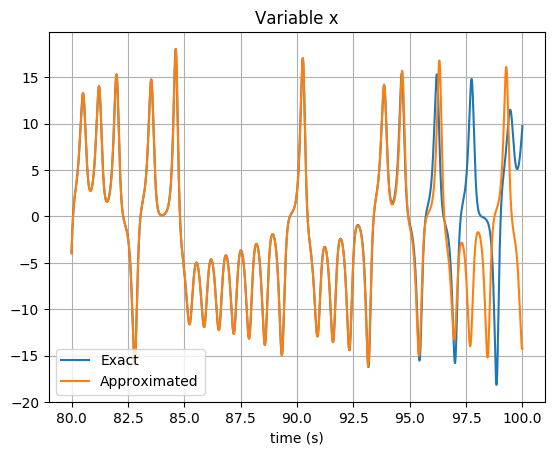

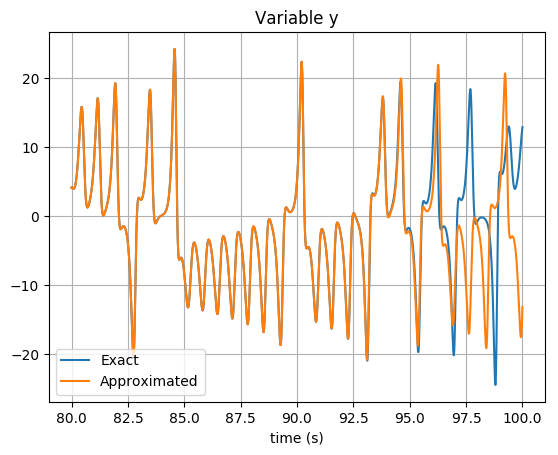

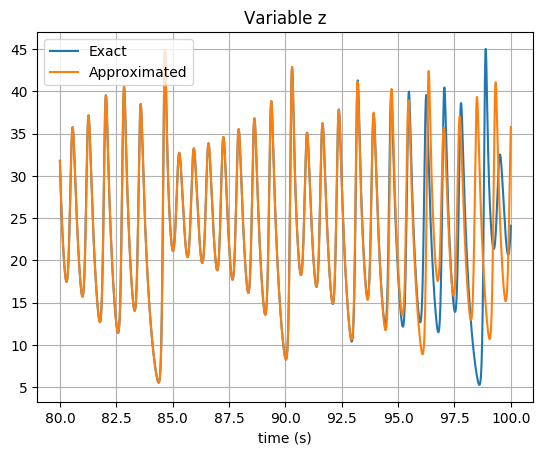

In [20]:
tags = ['x', 'y', 'z']

for var in range(n_field):

    plt.title(f"Variable {tags[var]}")
    plt.plot(t_test, test_field[:, var], label="Exact")
    plt.plot(t_test, estimated_field[:, var], label="Approximated")
    plt.xlabel("time (s)")
    plt.grid(True)
    plt.legend()
    plt.show()